### __Vine Wood Fungal Classification with Deep Learning__
By Jharana Adhikari and Yasaswin Palukuri

# Importing and Installing necessary libraries

In [1]:
# Id you haven't install the tensorflow yet just uncomment and run it
!pip install tensorflow scikit-learn keras matplotlib

Defaulting to user installation because normal site-packages is not writeable


In [2]:
# if you havenot installed opecv-python just uncomment it and run in your system
!pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable


In [4]:
import sys
!{sys.executable} -m pip install opencv-python

  Using cached opencv_python-4.11.0.86-cp37-abi3-win_amd64.whl.metadata (20 kB)
Using cached opencv_python-4.11.0.86-cp37-abi3-win_amd64.whl (39.5 MB)


    extract-msg (<=0.29.*)
                 ~~~~~~~^

[notice] A new release of pip is available: 24.1.2 -> 25.0
[notice] To update, run: C:\Users\yasas\AppData\Local\Programs\Python\Python311\python.exe -m pip install --upgrade pip


In [5]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, jaccard_score

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

### Declaring the path for data

In [6]:
#Dataset Path 
dataset_path = "./An eye on the vine"

In [7]:
# Loading all the images from various folders
def load_images_and_masks(dataset_path, img_size=(128, 128)):
    images, masks = [], []
    
    for category in ["Thumbnail images", "Original images"]:
        category_path = os.path.join(dataset_path, category)
        
        for subfolder in os.listdir(category_path):
            subfolder_path = os.path.join(category_path, subfolder)

            # Go deeper if needed (e.g., "With fungi", "Without fungi", "Microscope 1", "Microscope 2")
            for condition in os.listdir(subfolder_path):
                condition_path = os.path.join(subfolder_path, condition)
                
                # Images are color and masks are the black&white pics of fungi
                image_folder = os.path.join(condition_path, "images")
                mask_folder = os.path.join(condition_path, "masks")
                
                if not os.path.exists(image_folder) or not os.path.exists(mask_folder):
                    continue
                
                # List image & mask files
                image_files = sorted(os.listdir(image_folder))
                mask_files = sorted(os.listdir(mask_folder))
                
                for img_file, mask_file in zip(image_files, mask_files):
                    img_path = os.path.join(image_folder, img_file)
                    mask_path = os.path.join(mask_folder, mask_file)
                    
                    # Starting to work with loaded images and masks
                    img = cv2.imread(img_path)
                    img = cv2.resize(img, img_size) / 255.0
                    
                    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                    mask = cv2.resize(mask, img_size) / 255.0
                    
                    if img is not None and mask is not None:
                        images.append(img)
                        masks.append(mask.reshape(img_size + (1,)))  # Add channel dimension

    return np.array(images), np.array(masks)

### Creating x and y partitions to do train test split

In [8]:
# Load Data
IMG_SIZE = (128, 128)
X, y = load_images_and_masks(dataset_path, IMG_SIZE)

#### Doing train test split using scikit-learn

In [9]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

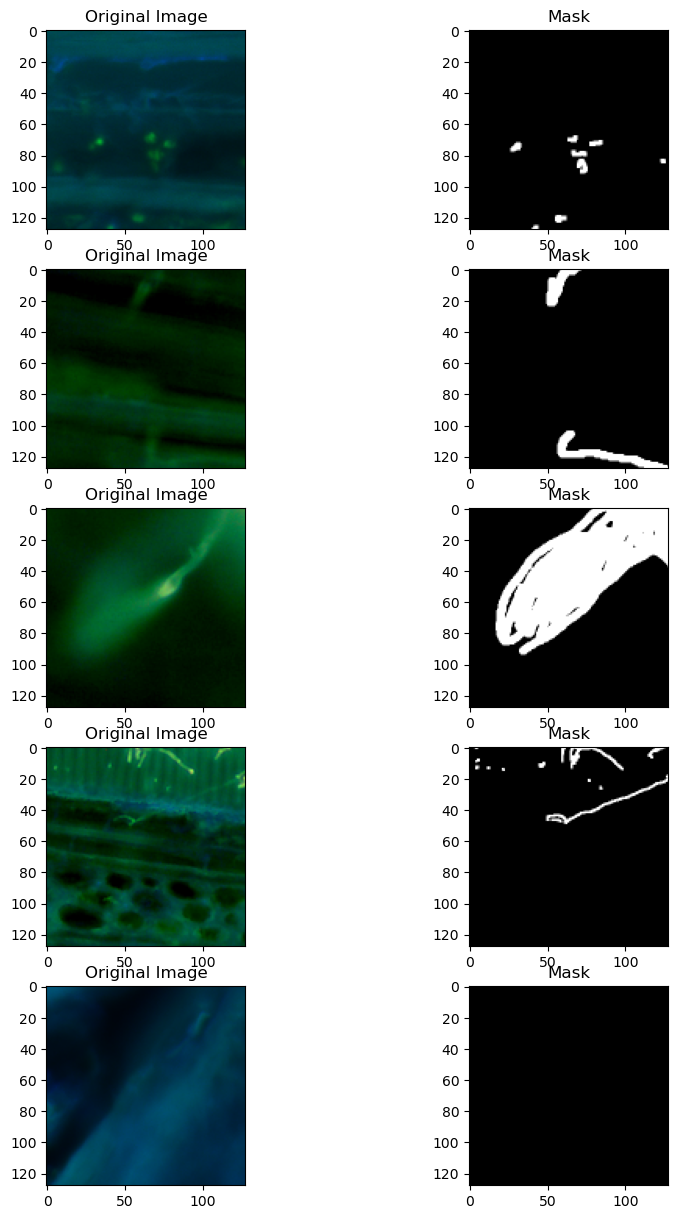

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


In [ ]:
# Display Sample Images & Masks
def display_samples(X, y, num_samples=5):
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, num_samples * 3))
    for i in range(num_samples):
        axes[i, 0].imshow(X[i])
        axes[i, 0].set_title("Original Image")
        axes[i, 1].imshow(y[i].squeeze(), cmap='gray')
        axes[i, 1].set_title("Mask")
    plt.show()

display_samples(X_train, y_train)

# Pixel Intensity Distribution
plt.figure(figsize=(6, 4))
sns.histplot(X_train.flatten(), bins=50, kde=True, color='blue')
plt.title("Pixel Intensity Distribution")
plt.show()



#### Creating a __`Convolutional Neural Network`___(CNN)_

Why __`U-Net Model`__?
* It's a CNN used for image segmentation
* Used with precise image processing like for medical, satellite and other's.

Here, in our case we are trying to find whether a vine is infected with fungi or not, and this is a perfect solution to work on.

In [10]:
#Define U-Net Model
def build_unet(input_shape=(128, 128, 3)):
    inputs = Input(input_shape)
    
    # Encoder
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    # Bottleneck
    c4 = Conv2D(256, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(256, (3, 3), activation='relu', padding='same')(c4)

    # Decoder
    u1 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c4)
    u1 = concatenate([u1, c3])
    c5 = Conv2D(128, (3, 3), activation='relu', padding='same')(u1)
    c5 = Conv2D(128, (3, 3), activation='relu', padding='same')(c5)

    u2 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c5)
    u2 = concatenate([u2, c2])
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same')(u2)
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same')(c6)

    u3 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c6)
    u3 = concatenate([u3, c1])
    c7 = Conv2D(32, (3, 3), activation='relu', padding='same')(u3)
    c7 = Conv2D(32, (3, 3), activation='relu', padding='same')(c7)

    # Output
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c7)
    
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

### Preparing a K-Fold to verify if the network is predicting properly or not.

In [12]:
# Train with K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
best_model = None
best_accuracy = 0

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
    print(f"\nTraining Fold {fold + 1}...")
    
    X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
    y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]
    
    model = build_unet()
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    model.fit(X_train_fold, y_train_fold, epochs=5, batch_size=18, validation_data=(X_val_fold, y_val_fold), callbacks=[early_stopping])
    
    val_loss, val_accuracy = model.evaluate(X_val_fold, y_val_fold)
    print(f"Validation Accuracy for Fold {fold + 1}: {val_accuracy:.4f}")
    
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_model = model


Training Fold 1...
Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 104s 3s/step - accuracy: 0.8187 - loss: 0.5247 - val_accuracy: 0.9276 - val_loss: 0.1857
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 85s 3s/step - accuracy: 0.9233 - loss: 0.1950 - val_accuracy: 0.9322 - val_loss: 0.1829
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.9384 - loss: 0.1680 - val_accuracy: 0.9239 - val_loss: 0.1773
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.9252 - loss: 0.1861 - val_accuracy: 0.9351 - val_loss: 0.1583
Epoch 5/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.9364 - loss: 0.1627 - val_accuracy: 0.9371 - val_loss: 0.1525
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.9396 - loss: 0.1550
Validation Accuracy for Fold 1: 0.9371

Training Fold 2...
Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 98s 3s/step - accuracy: 0.8579 - loss: 0.4967 - val_accuracy: 0.9393 - val_loss: 0.1696
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 80s 3s/step - accuracy: 0.9221 - loss: 0.1903 - val_accuracy: 0

#### Evaluating the results

In [13]:
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.9425 - loss: 0.1507
Test Accuracy: 0.9397


#### Displaying Sample Predictions

6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step


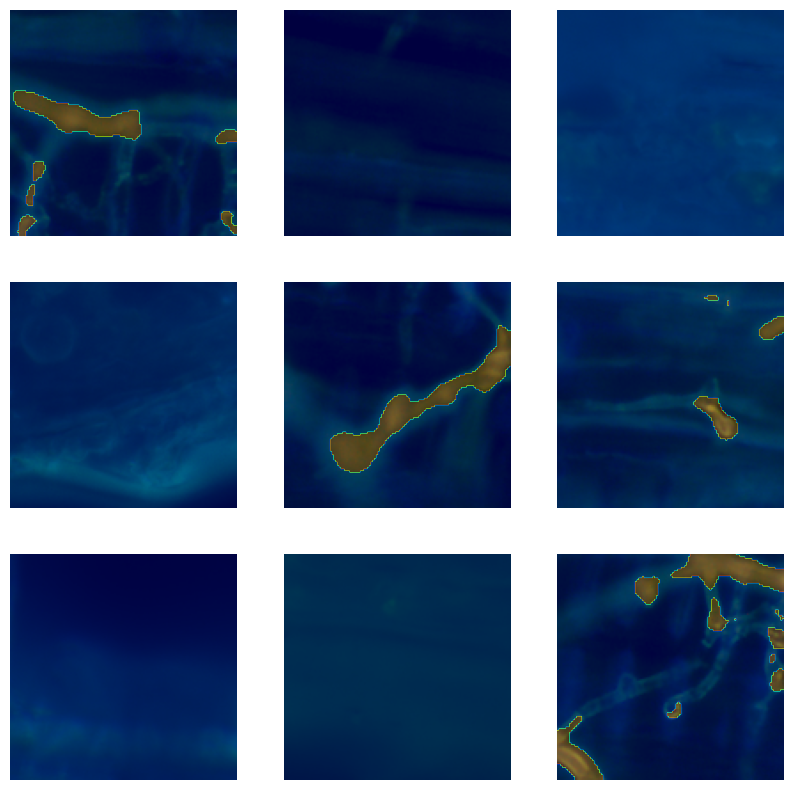

In [14]:
def display_sample_predictions(model, X_test, y_test):
    preds = model.predict(X_test)
    preds = (preds > 0.5).astype(np.uint8)  # Convert to binary mask
    
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    for i in range(9):
        ax = axes[i//3, i%3]
        ax.imshow(X_test[i])
        ax.imshow(preds[i].squeeze(), cmap="jet", alpha=0.5)  # Overlay prediction
        ax.axis("off")
    plt.show()

display_sample_predictions(best_model, X_test, y_test)